# Predicting Heart Disease from Cleveland Database  

Authors: Albert C. Halim, Archer Liu, Stephanie Wu, & Ziyuan Zhao  
Date: November 18, 2024  

# Summary

In this project, we developed classification models using the Cleveland Heart Disease dataset to predict the presence of heart disease based on various clinical measurements. We evaluated the performance of four models: Support Vector Classifier (SVC), Linear Regression (adapted for classification), a Dummy Classifier (as a baseline), and a Decision Tree Classifier.


# Introduction

# Methods

## Data

## Analysis

## Results & Discussion

In [3]:
# File handling
import os
import requests
import zipfile

# Data handling
import numpy as np
import pandas as pd

# Preprocessing
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

# Machine Learning
from scipy.stats import expon, lognorm, loguniform, randint, uniform, norm
from sklearn.model_selection import  RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

# Scoring Metrics
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer, f1_score, recall_score, precision_score

In [2]:
# Create the directory if it doesn't exist
raw_dir = "../data/raw"
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)

# Download data as zip
url = "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
response = requests.get(url)

# Save the zip file to the specified directory
zip_path = os.path.join(raw_dir, "heart+disease.zip")
with open(zip_path, 'wb') as f:
    f.write(response.content)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(raw_dir)

In [4]:
# read in data
colnames = [
    "age",       
    "sex",       
    "cp",        
    "trestbps",  
    "chol",      
    "fbs",       
    "restecg",   
    "thalach",   
    "exang",     
    "oldpeak",   
    "slope",     
    "ca",        
    "thal",      
    "num"  
]

heart_disease = pd.read_csv("../data/raw/processed.cleveland.data", names=colnames, header=None)
# Replace missing values with nan for ease of computational handling
heart_disease.replace('?', np.nan, inplace=True)
# heart_disease = heart_disease.dropna()
# Update the target variable 'num' (map values greater than 1 to 1)
heart_disease['num'] = heart_disease['num'].apply(lambda x: 1 if x > 1 else x)

In [5]:
# Scale and split into train & test
np.random.seed(522)
set_config(transform_output="pandas")

# Create the split
heart_disease_train, heart_disease_test = train_test_split(
    heart_disease, train_size=0.70, stratify=heart_disease["num"]
)
# Create the directory if it doesn't exist
processed_dir = "../data/processed"
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)
heart_disease_train.to_csv("../data/processed/heart_disease_train.csv")
heart_disease_test.to_csv("../data/processed/heart_disease_test.csv")

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

results_dir = "../results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Load the raw data
file_path = "../data/processed/heart_disease_train.csv"  # Adjusted name
raw_data = pd.read_csv(file_path)
print(raw_data.head())

   Unnamed: 0   age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  \
0         126  56.0  0.0  4.0     200.0  288.0  1.0      2.0    133.0    1.0   
1         261  58.0  0.0  2.0     136.0  319.0  1.0      2.0    152.0    0.0   
2         102  57.0  0.0  4.0     128.0  303.0  0.0      2.0    159.0    0.0   
3         154  64.0  1.0  4.0     120.0  246.0  0.0      2.0     96.0    1.0   
4         275  64.0  1.0  1.0     170.0  227.0  0.0      2.0    155.0    0.0   

   oldpeak  slope   ca  thal  num  
0      4.0    3.0  2.0   7.0    3  
1      0.0    1.0  2.0   3.0    3  
2      0.0    1.0  1.0   3.0    0  
3      2.2    3.0  1.0   3.0    3  
4      0.6    2.0  0.0   7.0    0  


<div style="background-color:#cce7ff; padding:15px; border-radius:5px; border: 2px solid #007acc;">
    <h3 style="color:#007acc;">📊 Visualization Section</h3>
    <p style="font-size:14px; color:#005f99;">
        The following plots provide insights into the dataset, including target variable distribution, categorical feature relationships, 
        and model performance (confusion matrix). Each visualization highlights critical aspects of the analysis.
    </p>
</div>


## Data Set Summary

The heart disease dataset used in this project is obtained from the UC Irvine Machine Learning Repository. The dataset contains 13 features, and the target is a binary variable (`num`) where:

- **`0`**: No presence of heart disease
- **`1` or higher**: Presence of heart disease.

Out of the 13 features:
- **8 are categorical** (e.g., `sex`, `cp`, `thal`).
- **5 are numeric** (e.g., `age`, `chol`, `thalach`).

These features include various physiological parameters, such as:
- **Resting blood pressure**,
- **Serum cholesterol levels**,
- **Maximum heart rate achieved**.

Additionally, it records potential signs of heart disease, such as chest pain type (`cp`) and exercise-induced angina (`exang`).

The dataset contains **303 observations**, and the original study used a Bayesian model to estimate the probability of having heart disease (Robert et al., 1989).


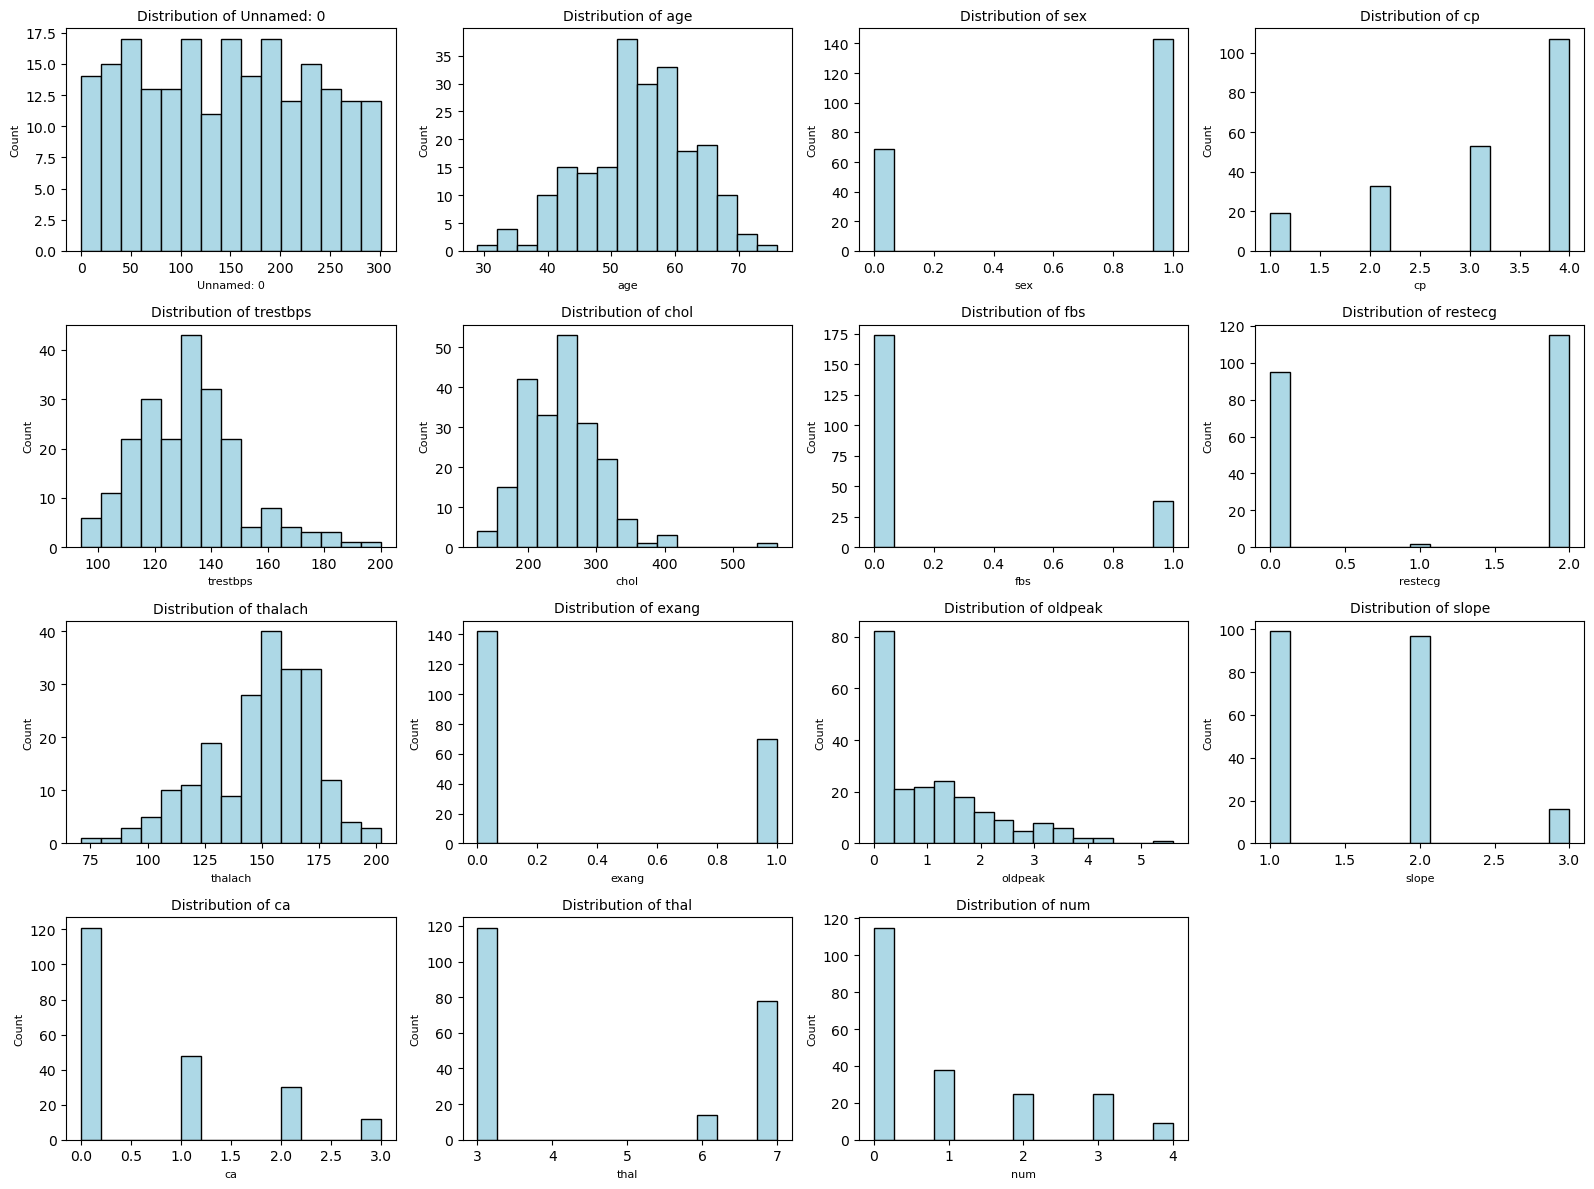

In [5]:
# General feature analysis for numeric features
numeric_features = raw_data.select_dtypes(include=["float64", "int64"]).columns

plt.figure(figsize=(16, 12))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 4, i)  # Adjust rows/columns as needed
    plt.hist(raw_data[feature], bins=15, color="lightblue", edgecolor="black")
    plt.title(f"Distribution of {feature}", fontsize=10)
    plt.xlabel(feature, fontsize=8)
    plt.ylabel("Count", fontsize=8)
plt.tight_layout()
plt.savefig(f"{results_dir}/raw_feature_distributions.png", dpi=300)
plt.show()

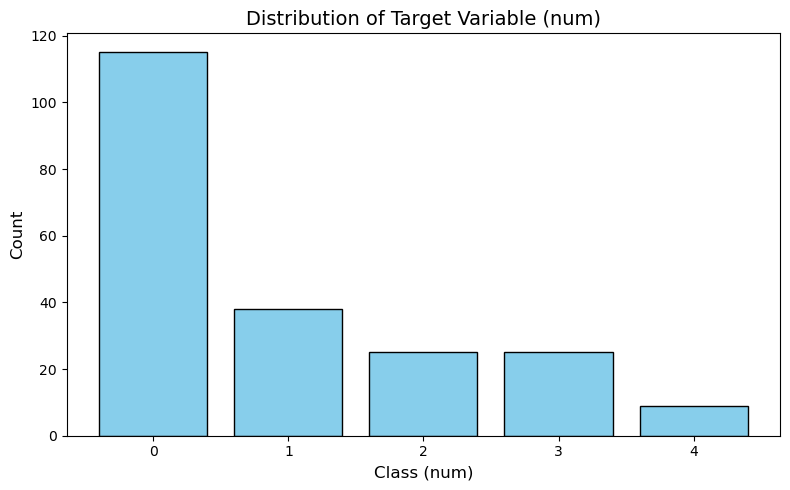

In [6]:
# Count the occurrences of each class in "num"
target_counts = raw_data["num"].value_counts()

# Plot the target variable distribution
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index, target_counts.values, color="skyblue", edgecolor="black")
plt.title("Distribution of Target Variable (num)", fontsize=14)
plt.xlabel("Class (num)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(target_counts.index, fontsize=10)
plt.tight_layout()

# Save the plot
plt.savefig(f"{results_dir}/target_variable_distribution.png", dpi=300)
plt.show()

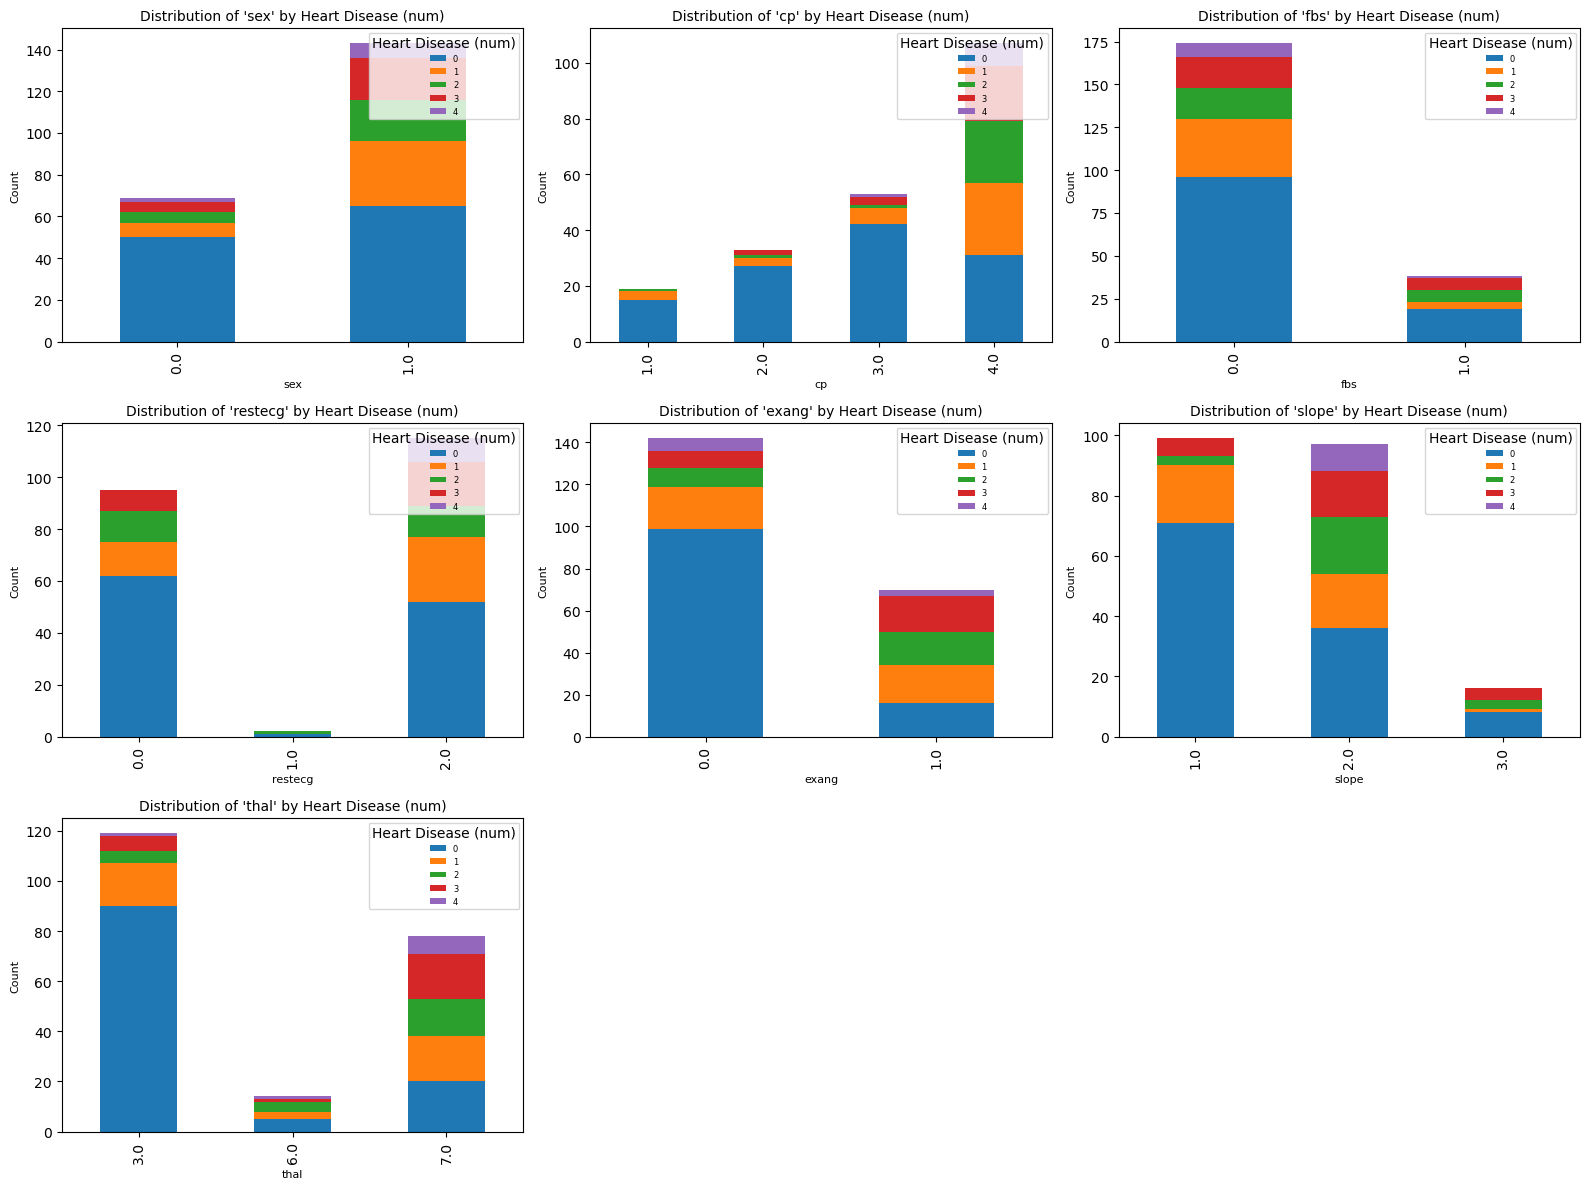

In [7]:
# List of categorical features to visualize
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

# Create subplots for all categorical variables
plt.figure(figsize=(16, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)  # Adjust rows/columns based on the number of features
    counts = raw_data.groupby([feature, 'num']).size().unstack()
    counts.plot(kind='bar', stacked=True, ax=plt.gca(), color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
    plt.title(f"Distribution of '{feature}' by Heart Disease (num)", fontsize=10)
    plt.xlabel(feature, fontsize=8)
    plt.ylabel("Count", fontsize=8)
    plt.legend(title="Heart Disease (num)", loc='upper right', fontsize=6)
    plt.tight_layout()

# Save the combined plot
plt.savefig(f"{results_dir}/categorical_features_distribution.png", dpi=300)
plt.show()

/var/folders/94/2v09812s7_bb1q5dd2g4v8_h0000gn/T/ipykernel_38397/1984716198.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cls) for cls in raw_data["num"].unique()])
/var/folders/94/2v09812s7_bb1q5dd2g4v8_h0000gn/T/ipykernel_38397/1984716198.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cls) for cls in raw_data["num"].unique()])
/var/folders/94/2v09812s7_bb1q5dd2g4v8_h0000gn/T/ipykernel_38397/1984716198.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cls) for cls in raw_data["num"].unique()])
/var/folders/94/2v0981

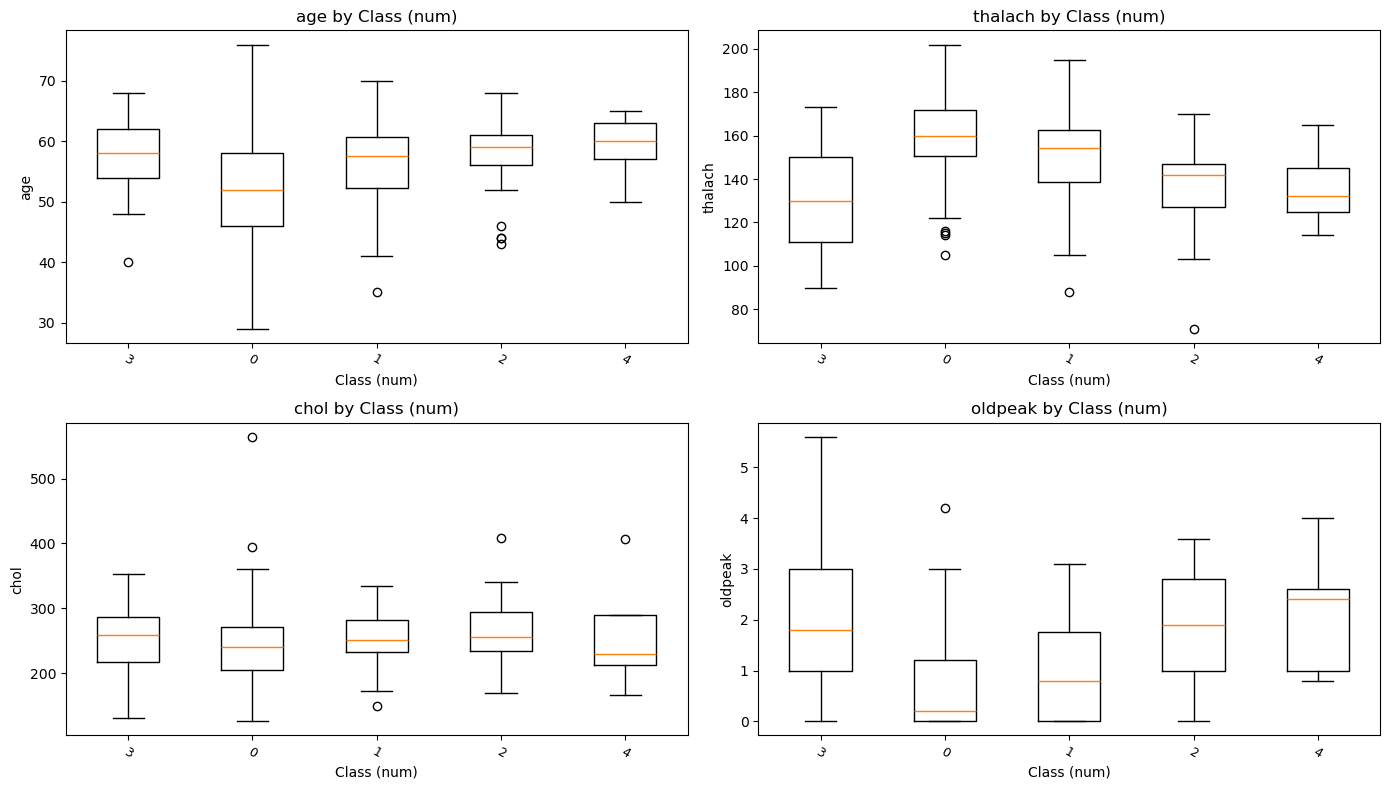

In [8]:
# List of numeric features for boxplots
selected_features = ["age", "thalach", "chol", "oldpeak"]

plt.figure(figsize=(14, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    # Boxplot for each feature grouped by 'num'
    data = [raw_data[raw_data["num"] == cls][feature] for cls in raw_data["num"].unique()]
    plt.boxplot(data, labels=[str(cls) for cls in raw_data["num"].unique()])
    plt.title(f"{feature} by Class (num)", fontsize=12)
    plt.xlabel("Class (num)", fontsize=10)
    plt.ylabel(feature, fontsize=10)
    plt.xticks(rotation=330, fontsize=9)
plt.tight_layout()
plt.savefig(f"{results_dir}/raw_boxplots_by_class.png", dpi=300)
plt.show()

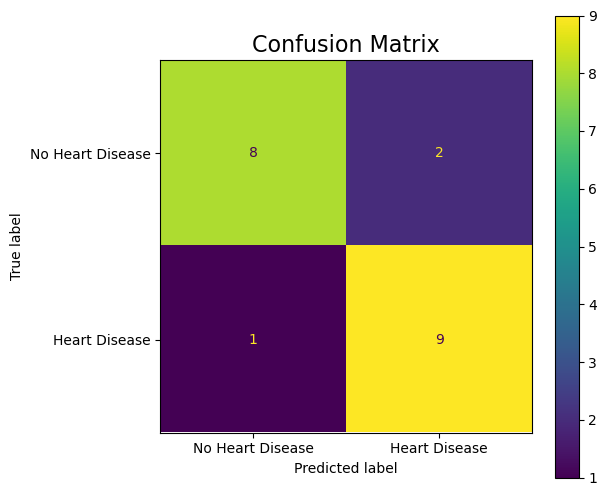

In [9]:
# Example true and predicted labels (replace with your actual model predictions)
y_true = np.array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1])
y_pred = np.array([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1])

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create labels for the matrix (optional)
labels = ["No Heart Disease", "Heart Disease"]

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="viridis", ax=ax, colorbar=True)
plt.title("Confusion Matrix", fontsize=16)

# Save the plot
plt.savefig(f"{results_dir}/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

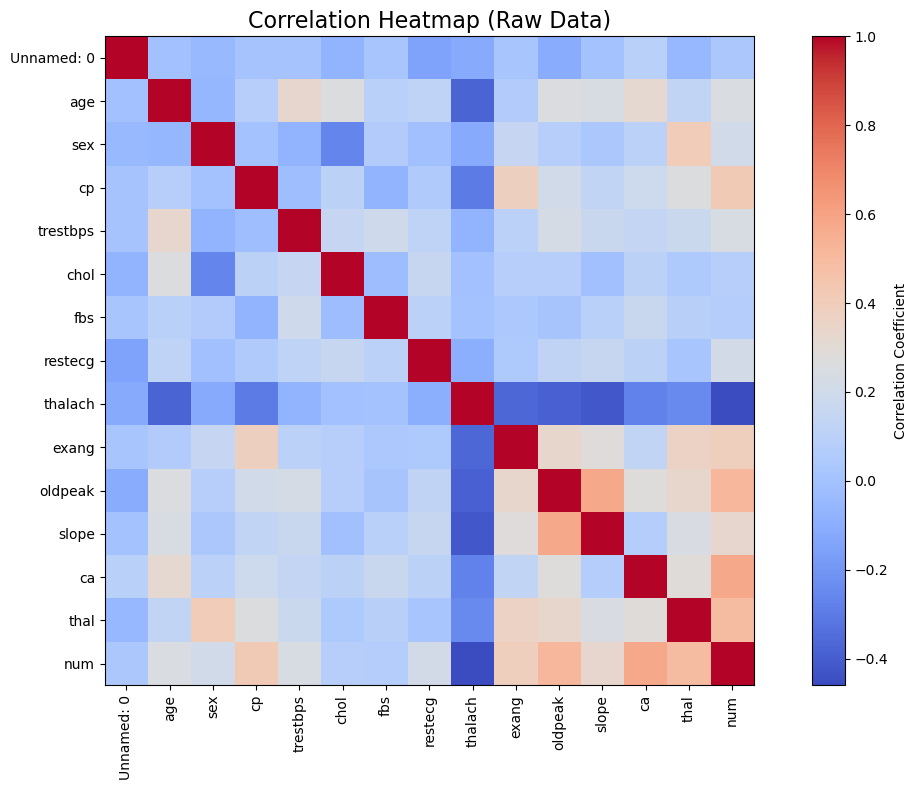

In [10]:
# Compute the correlation matrix
correlation_matrix = raw_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation Coefficient")
plt.title("Correlation Heatmap (Raw Data)", fontsize=16)

# Add x and y ticks with feature names
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

plt.tight_layout()
plt.savefig(f"{results_dir}/raw_correlation_heatmap.png", dpi=300)
plt.show()

<div style="background-color:#fce8e6; padding:15px; border-radius:5px; border: 2px solid #ff6666;">
    <h3 style="color:#ff6666;">✅ Visualization Section Completed</h3>
    <p style="font-size:14px; color:#cc0000;">
        This concludes the visualization section. The insights derived from these plots will be used to guide subsequent analyses 
        and modeling steps. If additional visualizations are required, they can be added here.
    </p>
</div>

In [11]:
ca_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    StandardScaler()
)

thal_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(sparse_output=False)
)

heart_disease_preprocessor = make_column_transformer(
    (ca_pipeline, ['ca']),  # Apply imputation and scaling to 'ca'
    (thal_pipeline, ['thal']),  # Apply imputation and encoding to 'thal'
    (OneHotEncoder(sparse_output=False), ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']),
    (StandardScaler(), ["age", "trestbps", "chol", "thalach", "oldpeak"]),
    remainder='passthrough',
    verbose_feature_names_out=True
)

heart_disease_preprocessor.fit(heart_disease_train)
scaled_heart_disease_train = heart_disease_preprocessor.transform(heart_disease_train)
scaled_heart_disease_test = heart_disease_preprocessor.transform(heart_disease_test)

scaled_heart_disease_train.to_csv("../data/processed/scaled_heart_disease_train.csv")
scaled_heart_disease_test.to_csv("../data/processed/scaled_heart_disease_test.csv")

In [6]:
X_train = heart_disease_train.drop(columns=['num'])
y_train = heart_disease_train['num']
X_test = heart_disease_test.drop(columns=['num'])
y_test = heart_disease_test['num']

In [23]:
def randomized_search(X_train, y_train, model, param_dist, n_iter=100, cv=5, random_state=123):
    """
    Performs RandomizedSearchCV on the specified model and returns the best model.
    
    Parameters:
    X_train : DataFrame
        Training features
    y_train : Series
        Training labels
    model : estimator
        The model to be tuned
    param_dist : dict
        Hyperparameter distribution for RandomizedSearchCV
    n_iter : int, optional, default=100
        Number of iterations for RandomizedSearchCV
    cv : int, optional, default=5
        Number of cross-validation folds
    random_state : int, optional, default=123
        Random seed for reproducibility

    Returns:
    best_model : estimator
        The best model after RandomizedSearchCV
    """
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=n_iter, cv=cv, n_jobs=-1, random_state=random_state,
                                       return_train_score=True)
    
    # Fit the model
    random_search.fit(X_train, y_train)

    # Return the best model found by RandomizedSearchCV
    return random_search.best_estimator_

In [24]:
# This function is taken from UBC 571 Course
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [25]:
results_dict = {}
models = {
    "Dummy": DummyClassifier(random_state=123),
    "SVC": SVC(random_state=123)
}

for model in models.items():
    pipe = make_pipeline(heart_disease_preprocessor, model[1])
    results_dict[model[0]] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True
    )

income_pred_results_df = pd.DataFrame(results_dict).T
income_pred_results_df

,fit_time,score_time,test_score,train_score
Dummy,0.018 (+/- 0.003),0.011 (+/- 0.002),0.543 (+/- 0.007),0.542 (+/- 0.002)
SVC,0.017 (+/- 0.001),0.009 (+/- 0.001),0.844 (+/- 0.043),0.929 (+/- 0.017)


In [33]:
svc_param = {
    "gamma": loguniform(1e-4, 1e2),
    "C": loguniform(1e-4, 1e2),
    "class_weight": [None, "balanced"]
}

best_svc_model = randomized_search(X_train, y_train, SVC(random_state=123), svc_param)

# Calculate the train score (accuracy on training data)
train_score = best_svc_model.score(X_train, y_train)
print("SVC Best Model Train Accuracy Score: ", train_score)

SVC Best Model Train Accuracy Score:  0.8584905660377359


# Results